<a href="https://colab.research.google.com/github/skrofman/Applied-Machine-Learning/blob/master/DATA_310_Lecture_35_Spring_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 310 Lecture 35 - Spring 2021



<font face="Calibri" color="darkgreen" size=8> Dimensionality Reduction</font>

<font color='crimson'>**Why we care about dimensionality:**</font> Big data is characterized not just by a large number of observations, but also by very large number of input features. Very often the problem is that not all features in the data are important for solving the regression or the classification problems. At the same time, it is difficult to computationally accomodate too many input features into the model.

<font color='deepskyblue'>**Possible Solutions (Regression Problems):**</font> Algorithms for feature selection and feature extraction.



<font color='green'> Feature Selection: What data should you put into your model? For linear regression models the variable selection approaches include backward elimination, forward selection, bidirectional elimination and penalized regression techniques such as LASSO or Elastic Net.

<font color='navy'>  General Heuristics: Reducing the number of variables can greatly aid interpretability, reduce the chances your violating key assumptions, and let you go beyond simple prediction. Furthermore, smaller models (parsimonious models) are easier to update and interpret - every column of data you add is a column of data you have to collect in the future if you ever want to use your model again. Less is better - don’t invest resources to collect data you don’t need!</font>

**Backward Elimination:**

Select a significance for model inclusion (i.e., 0.05)

Fit full model with everything

Remove the predictor with the highest P-value (if it is greater than your threshold in step 1).

Continue this process until all models have a significance less than your threshold.

**Forward Selection:**

Select a significance level (i.e., 0.05).

Fit all regressions possible with only one variable. Select the model with the lowest P value.

Repeat this, adding the variable from step ii.

Keep going until no p values are less than your threshold in step i.

**Bidirectional Elimination:**

Choose a p-value for staying and entering into the model (i.e., 0.05).

Do forward selection to pick the best variables.

Do backward elimination and remove variables.

Repeat until no variables are added or removed in either step.

The problem with the stepwise approaches is that they are very sensitive to model assumptions.

<font color='blue'>**Variable Selection:**</font> most of the methods are based on *penalized regression techniques* such as Ridge, LASSO and ElasticNet.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
y

In [ ]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
# here we apply stepwise regression
result = stepwise_selection(X,y,[],0.0001,0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  LSTAT                          with p-value 5.0811e-88
Add  RM                             with p-value 3.47226e-27
Add  PTRATIO                        with p-value 1.64466e-14
Add  DIS                            with p-value 1.66847e-05
Add  NOX                            with p-value 5.48815e-08


In [ ]:
result

['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
df=X
model = RandomForestRegressor(random_state=1234, max_depth=5,n_estimators=100)
df=pd.get_dummies(df)
model.fit(df,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

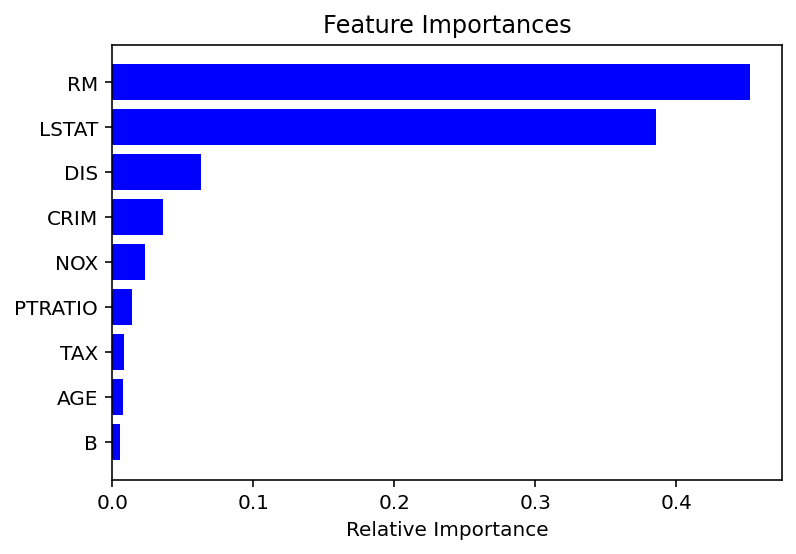

In [ ]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Penalized regression can be used for variable selection

In [ ]:
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scale = StandardScaler()

In [ ]:
Xs = scale.fit_transform(X)

In [ ]:
model = lm.Lasso(alpha=0.3)
model.fit(Xs,y)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Small alpha may not result in weights being zero however a bigger alpha may help with a meaningful variable selection.

In [ ]:
model.coef_

NameError: ignored

In [ ]:
list(X.columns[np.abs(model.coef_)>1e-1])
X.shape[1]

NameError: ignored

In [ ]:
v = -np.sort(-np.abs(model.coef_))
for i in range(X.shape[1]):
  print(X.columns[np.abs(model.coef_)==v[i]])

In [ ]:
model = lm.ElasticNet(alpha=0.25,l1_ratio = 0.5)
model.fit(Xs,y)
model.coef_

In [ ]:
v = -np.sort(-np.abs(model.coef_))
for i in range(X.shape[1]):
  print(X.columns[np.abs(model.coef_)==v[i]])

## Relationship between Coefficients and Regularization.
Keywords: coefficients, regularization, $\alpha$ hyperparameter and L1 ratio

Given a data set with multiple features, we want to show how can we visualize the paths of the coefficients when the strentgh of the regularization changes.

Reference: https://refactored.ai/microcourse/notebook?path=content%2F05-Regression_models_in_Machine_Learning%2F05-Regularization%2F01-Regularization.ipynb

In [ ]:
from sklearn.model_selection import cross_val_score

ridge_reg = lm.Ridge(alpha=0.75)
scores = cross_val_score(ridge_reg, X, y, cv=5)
acc_r=scores.mean()
acc_r

0.38484654249862976

In [ ]:
n_alphas = 2000
alphas = np.logspace(-5, 6, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

(2.818382931264455e-06,
 3548133.892335753,
 -3.3082503089211266,
 6.367975412379308)

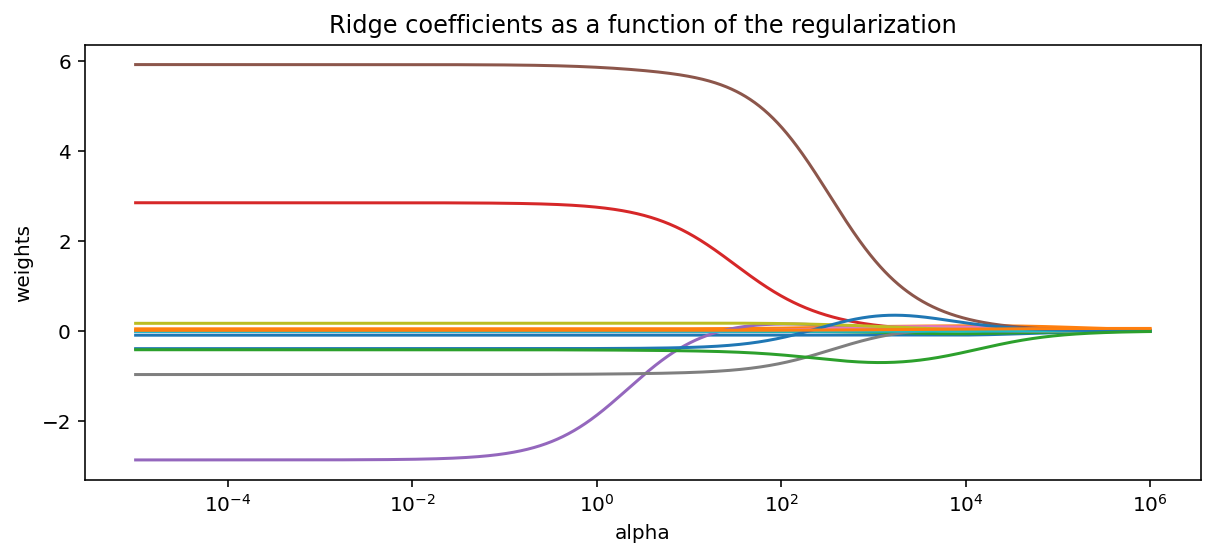

In [ ]:
# Display results
plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

In [ ]:
n_alphas = 2000
alphas = np.logspace(-5, 6, n_alphas)

coefs = []
for a in alphas:
    lasso = linear_model.ElasticNet(alpha=a,l1_ratio=0.5, fit_intercept=False)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

(2.818382931264455e-06, 3548133.892335753, -3.3030769463823, 6.367439290283742)

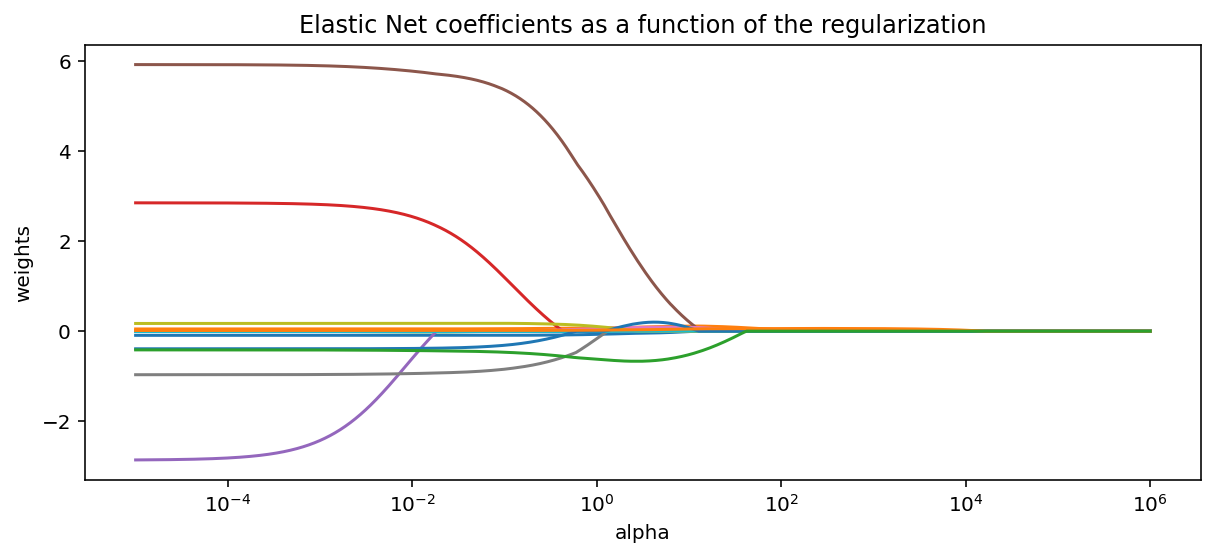

In [ ]:
# Display results
plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net coefficients as a function of the regularization')
plt.axis('tight')

In [ ]:
from itertools import cycle
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


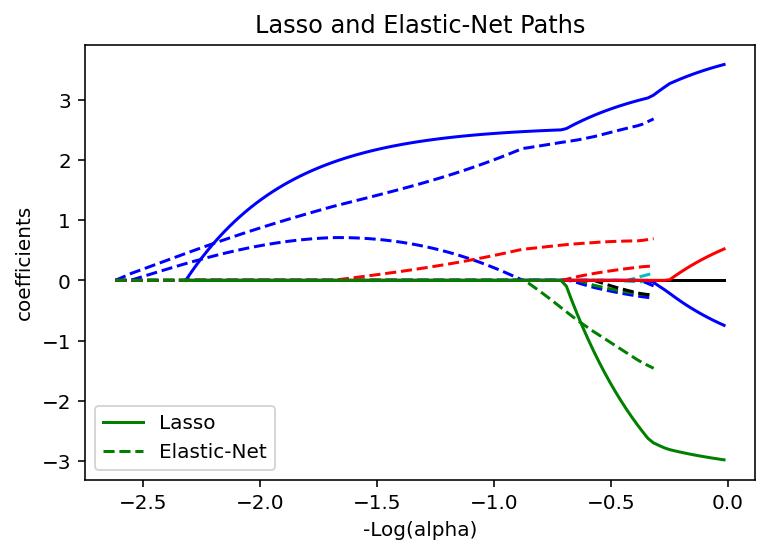

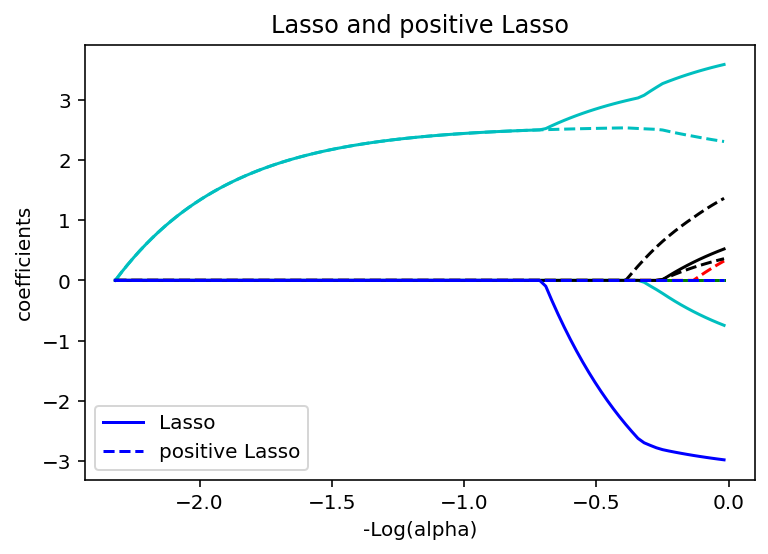

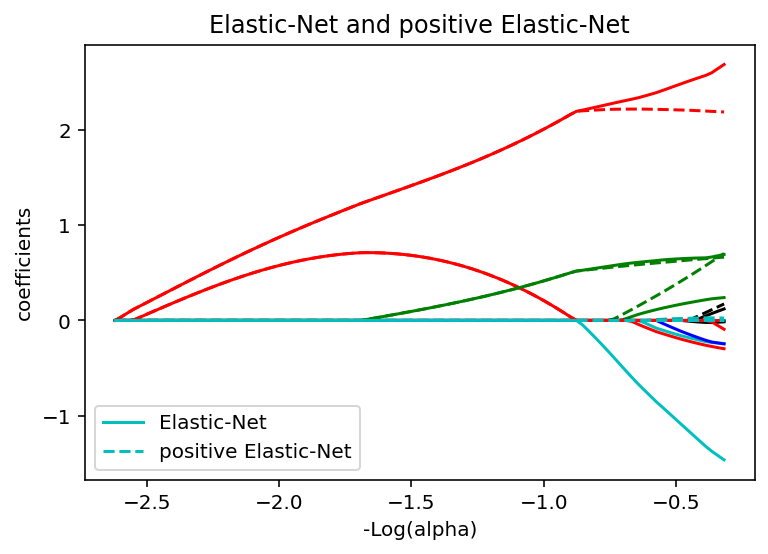

In [ ]:
X, y = datasets.load_boston(return_X_y=True)


X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.5, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.5, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [ ]:
model = lm.ElasticNet()
params = [{'alpha':np.linspace(1e-3,2,100),'l1_ratio':np.linspace(1e-3,1,10)}]
gs = GridSearchCV(estimator=model,cv=10,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(Xs,y)
print(gs_results.best_params_)
print('The best MSE is: ', np.abs(gs_results.best_score_))

{'alpha': 0.19185929648241207, 'l1_ratio': 0.001}
The best MSE is:  31.134038270278893


##<font color='forestgreen'> Feature Extraction </font>

Heuristically, feature extraction focuses on how to scale, rotate, or otherwise redefine (feature engineering) your data to create a smaller number of variables that summarize all of your other variables in the way most helpful to predict your outcome.

<font color='salmon'>**Main Idea:**</font> we can summarize the contribution of a subset of features based on finding the direction of the biggest variablity or variance. Such directions, that summarize most of the variablility in the data, are called principal components.

The following is an example in two dimensions:
<figure>
<center>
<img src='https://drive.google.com/uc?id=1Pu07tYhEWeA7hY9Sg3pZ8XAD62-ctQ_6' 
width='400px' />
<figcaption>Example of PCA in 2D</figcaption></center>
</figure>

The direction along the vector $\vec{PC}_1$ is the first principal component; along this direction we have the highest variance. The second principal component, $\vec{PC}_2$, is perpendicular to the first one.

<font color='crimson'>**Important:**</font> For regression problems we want to first rank the principal components and select only the first few that summarize in total more than 99% of the variance in the data set. Such ranking is possible by using a linear algebra concept (such as eigenvalues). The whole process is called Principal Component Analysis, abbreviated PCA.



(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

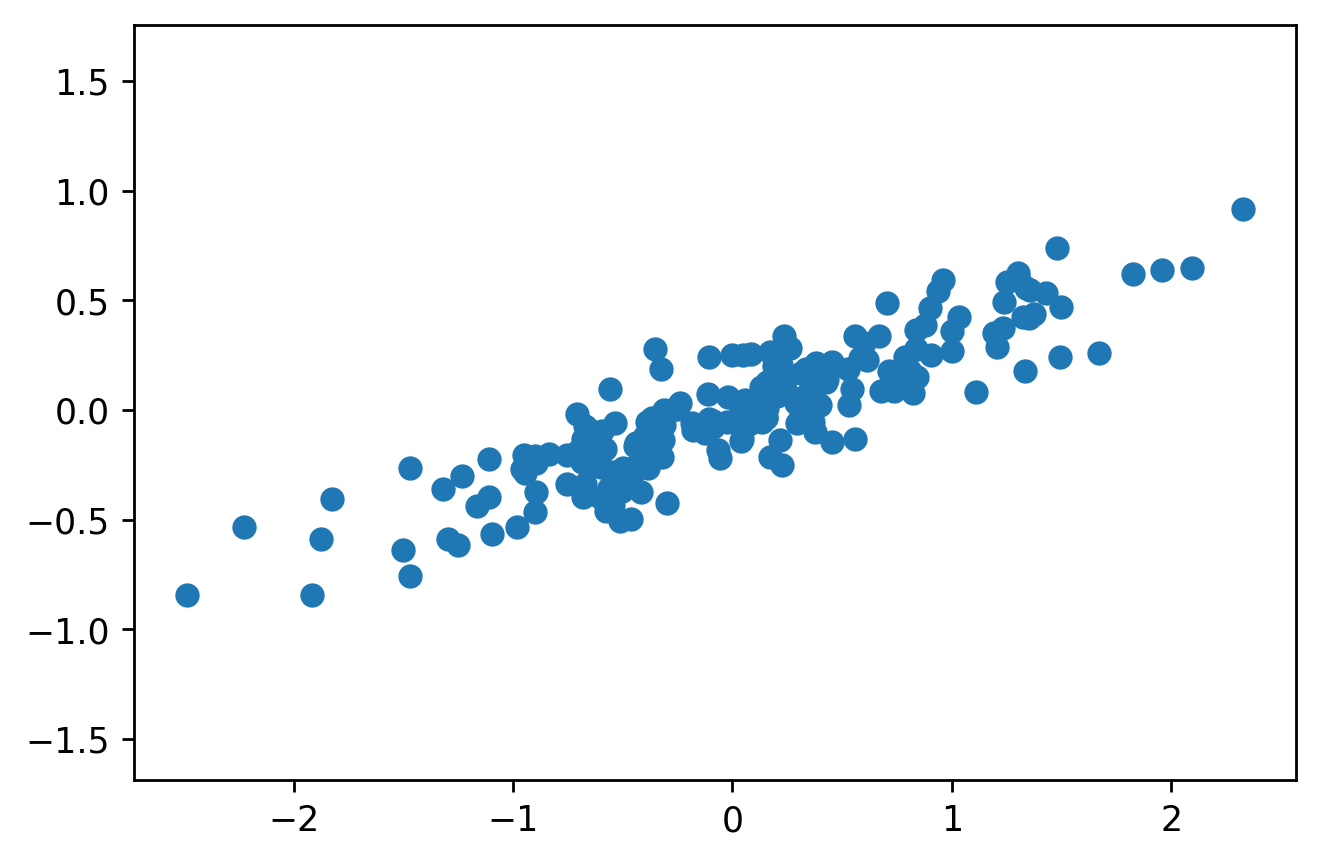

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

Base of the scatter plot we see the direction of maximum variance.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


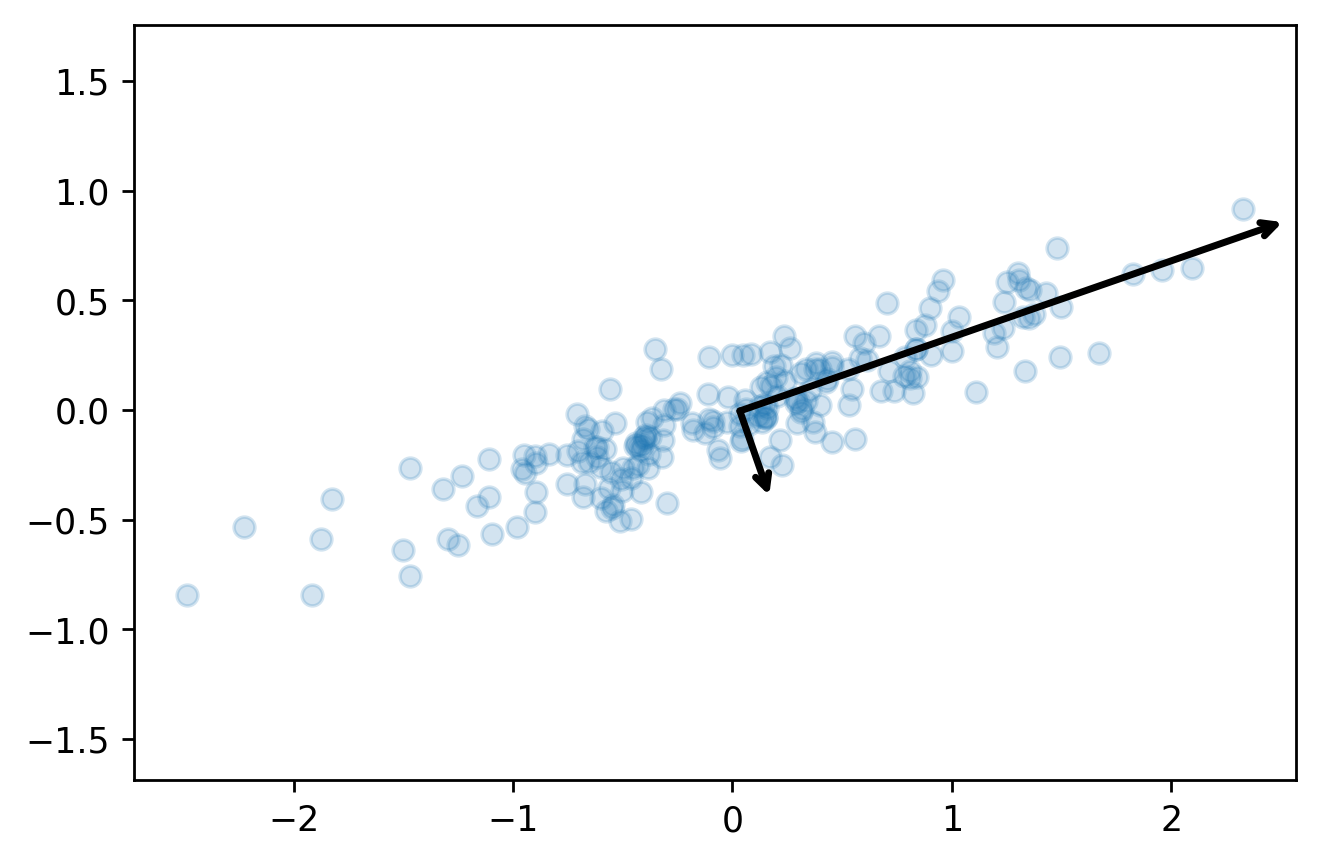

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = -vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

##<font color='forestgreen'> Classification Problems</font>

In classification problems we are interested to find, for example, the direction under which, if we project the features, we get the best accuracy for separating the classes

<figure>
<center>
<img src='https://drive.google.com/uc?id=1JvHzrEKwsMhKV4ma4ZlCkBlCGbq0lc4U' 
width='450px' />
<figcaption>Example of LDA in 2D</figcaption></center>
</figure>


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

NameError: ignored

In [ ]:
df.head(5)

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Sepal Length', fontsize = 15)
ax.set_ylabel('Sepal Width', fontsize = 15)
ax.set_title('Sepal Dimensions', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(df.loc[indicesToKeep, 'sepal length']
               , df.loc[indicesToKeep, 'sepal width']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Petal Length', fontsize = 15)
ax.set_ylabel('Petal Width', fontsize = 15)
ax.set_title('Petal Dimensions', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(df.loc[indicesToKeep, 'petal length']
               , df.loc[indicesToKeep, 'petal width']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
             columns = ['Principal Component 1', 'Principal Component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf.head()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### An application with LDA


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(principalComponents, y.ravel())

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('lda 1', fontsize = 15)
ax.set_ylabel('lda 2', fontsize = 15)
ax.set_title('Linear Discriminant Analysis', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(X_lda[indicesToKeep,0]
               , X_lda[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Required Reading:
https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/